![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Análisis de sentimientos y técnicas de NLP

En este taller podrán poner en práctica sus conocimientos sobre las diferentes técnicas para el procesamiento de lenguaje natural. El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción sentimientos de viajeros en Twitter

En este taller se usará el conjunto de datos de sentimientos sobre distintas aerolíneas de EE.UU. provenientes de Twitter. Cada observación contiene si el sentimiento de los tweets es positivo, neutral o negativo teniendo en cuenta distintas variables como aerolínea y las razones de los sentimientos negativos (como "retraso en el vuelo" o "servicio grosero"). El objetivo es predecir el sentimiento asociado a cada tweet. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('ggplot')

In [2]:
# Lectura de la información de archivo .zip
tweets = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/Tweets.zip', index_col=0)

# Visualización dataset
print(tweets.info())
tweets.head()

<class 'pandas.core.frame.DataFrame'>
Index: 14640 entries, 570306133677760513 to 569587140490866689
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airline_sentiment             14640 non-null  object 
 1   airline_sentiment_confidence  14640 non-null  float64
 2   negativereason                9178 non-null   object 
 3   negativereason_confidence     10522 non-null  float64
 4   airline                       14640 non-null  object 
 5   airline_sentiment_gold        40 non-null     object 
 6   name                          14640 non-null  object 
 7   negativereason_gold           32 non-null     object 
 8   retweet_count                 14640 non-null  int64  
 9   text                          14640 non-null  object 
 10  tweet_coord                   1019 non-null   object 
 11  tweet_created                 14640 non-null  object 
 12  tweet_location                9907 

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
# Impresión tamaño del cojunto de datos
tweets.shape

(14640, 14)

### Análisis descriptivo

In [4]:
# Cuenta de tweets por cada sentimiento
tweets['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [5]:
# Cuenta de tweets por cada aerolínea
tweets['airline'].value_counts()

airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: count, dtype: int64

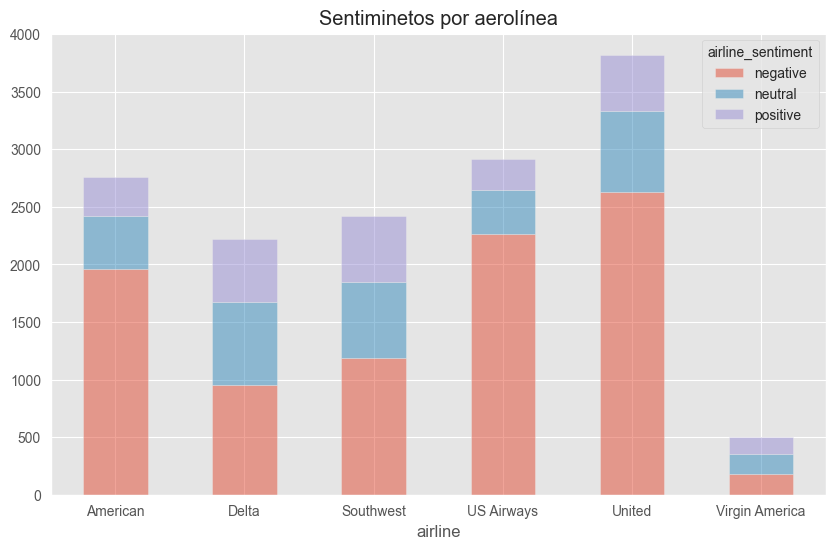

In [6]:
# Plot con cuenta de tweets por cada aerolínea y sentimiento
pd.crosstab(index = tweets["airline"],columns = tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiminetos por aerolínea");

In [7]:
# Tabla con cuenta de tweets por cada aerolínea y sentimiento
tabla_sentimientos = pd.crosstab(index=tweets["airline"], columns=tweets["airline_sentiment"])
print(tabla_sentimientos)

airline_sentiment  negative  neutral  positive
airline                                       
American               1960      463       336
Delta                   955      723       544
Southwest              1186      664       570
US Airways             2263      381       269
United                 2633      697       492
Virgin America          181      171       152


### Liberias y Variables de interés y predicción

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score

# Descargar recursos de NLTK
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/jerssonm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jerssonm/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jerssonm/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jerssonm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
# Separación de variables predictoras (X) y de variable de interés (y)
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})

In [10]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Uso de CountVectorizer

En la celda 1 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [11]:
# Celda 1
# Creación del objeto CountVectorizer y ajuste a los datos de entrenamiento
count_vectorizer = CountVectorizer()
X_train_count = count_vectorizer.fit_transform(X_train)

# Transformación de los datos de prueba
X_test_count = count_vectorizer.transform(X_test)

# Creación y entrenamiento del modelo de Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators= 250, n_jobs=-1)
rf_model.fit(X_train_count, y_train)

# Predicción sobre el conjunto de prueba
y_pred_cv = rf_model.predict(X_test_count)

# Evaluación del modelo
accuracy_cv = accuracy_score(y_test, y_pred_cv)
print(f"La métrica Accuracy del modelo RF para Análisis de Sentimientos utilizando CountVectorizer() es: {accuracy_cv:.5}.")

La métrica Accuracy del modelo RF para Análisis de Sentimientos utilizando CountVectorizer() es: 0.77214.


El modelo de Random Forest entrenado con las características extraídas por CountVectorizer() pudo predecir correctamente el sentimiento de aproximadamente el 77.21% de los tweets en el conjunto de prueba.

### Punto 2 - Eliminación de Stopwords

En la celda 2 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **eliminen stopwords** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [12]:
# Celda 2
# Creación del objeto CountVectorizer con eliminación de stopwords
count_vectorizer_sw = CountVectorizer(stop_words=stopwords.words('english'))
X_train_count_sw = count_vectorizer_sw.fit_transform(X_train)
X_test_count_sw = count_vectorizer_sw.transform(X_test)

# Entrenamiento del modelo de Random Forest
rf_model.fit(X_train_count_sw, y_train)

# Predicción sobre el conjunto de prueba
y_pred_sw = rf_model.predict(X_test_count_sw)

# Evaluación del modelo
accuracy_sw = accuracy_score(y_test, y_pred_sw)
print(f"La métrica Accuracy del modelo RF para Análisis de Sentimientos utilizando CountVectorizer() con eliminación de -stop_words- es: {accuracy_sw:.5}.")

La métrica Accuracy del modelo RF para Análisis de Sentimientos utilizando CountVectorizer() con eliminación de -stop_words- es: 0.76449.


La métrica Accuracy del modelo de RF es ahora igual a 0.76449, lo que significa que el modelo predijo correctamente el sentimiento de aproximadamente el 76.45% de los tweets en el conjunto de prueba. La leve reducción en el desempeño de la métrica puede deberse la eliminación de variables del modelo manteniendo la correlación de las remanentes.

### Punto 3 - Lematización con verbos

En la celda 3 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [13]:
# Celda 3
# Función para lematizar el texto con verbos
def lemmatizer (text):
    lemmatizer = WordNetLemmatizer()
    words = text.lower().split()
    lemmatized_text = [lemmatizer.lemmatize(word, pos='v') for word in words]
    return ' '.join(lemmatized_text)

# Lematización a los datos de entrenamiento y prueba
X_train_lemmatized = X_train.apply(lemmatizer)
X_test_lemmatized = X_test.apply(lemmatizer)

# Creación y ajuste del CountVectorizer() con la lematización
count_vectorizer_lemmatized = CountVectorizer()
X_train_count_lemmatized = count_vectorizer_lemmatized.fit_transform(X_train_lemmatized)
X_test_count_lemmatized = count_vectorizer_lemmatized.transform(X_test_lemmatized)

# Entrenamiento del modelo de Random Forest
rf_model.fit(X_train_count_lemmatized, y_train)

# Predicción sobre el conjunto de prueba
y_pred_lm = rf_model.predict(X_test_count_lemmatized)

# Calcular y mostrar la precisión del modelo
accuracy_lm = accuracy_score(y_test, y_pred_lm)
print(f"La métrica Accuracy del modelo RF para Análisis de Sentimientos utilizando CountVectorizer() con lematización de verbos es: {accuracy_lm:.5}.")

La métrica Accuracy del modelo RF para Análisis de Sentimientos utilizando CountVectorizer() con lematización de verbos es: 0.77525.


El modelo de RF logró un incremento en la métrica Accuracy a un valor de 0.77525 al utilizar CountVectorizer() con lematización de los verbos. Esto significa que el modelo clasificó correctamente el sentimiento de alrededor del 77.53% de los tweets en el conjunto de prueba. Al emplear esta técnica, el modelo tuvo un mejor desempeño respecto al uso de la eliminación de -stop_words- e inclusive que el modelo con la vectorización exclusiva. El incremento en la métrica puede deberse al incremento en la correlación de las variables de predicción por la lematización.

### Punto 4 - Multiples técnicas

En la celda 4 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer, eliminen stopwords, lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [14]:
# Celda 4
# Función para lematizar el texto con verbos

# Lematización a los datos de entrenamiento y prueba
X_train_lemmatized = X_train.apply(lemmatizer)
X_test_lemmatized = X_test.apply(lemmatizer)

# Crear y ajustar el CountVectorizer con eliminación de stopwords y lematización
count_vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
X_train_count = count_vectorizer.fit_transform(X_train_lemmatized)
X_test_count = count_vectorizer.transform(X_test_lemmatized)

# Entrenar el modelo de Random Forest
rf_model.fit(X_train_count, y_train)

# Predecir sobre el conjunto de prueba
y_pred = rf_model.predict(X_test_count)

# Calcular y mostrar la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"La métrica Accuracy del modelo RF para Análisis de Sentimientos utilizando multiples técnicas es: {accuracy:.5}.")

La métrica Accuracy del modelo RF para Análisis de Sentimientos utilizando multiples técnicas es: 0.77608.


El modelo de RF obtuvo una precisión (Accuracy) de aproximadamente 0.77608, es decir, un desempeño mayor a los modelos de RF entrenados en los puntos anteriores, lo que indica que la combinación de CountVectorizer() con la eliminación de -stop_words- y la lematización de verbos increment el desempeño del modelo. La eliminación de palabras (variables) que no aportan al poder de predicción sumado al incremento de la correlación de la variables predictoras por la lematización mejoran la métrica del modelo.

### Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos (random forest) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

El mejor modelo para el Análisis de Sentimientos es el que usa la técnica: CountVectorizer() con Eliminación de -stop_words y Lematización de Verbos, con una métrica Accuracy de: 0.77608.
El peor modelo para el Análisis de Sentimientos es el que usa la técnica: CountVectorizer() con Eliminación de -stop_words-, con una métrica Accuracy de: 0.76449.


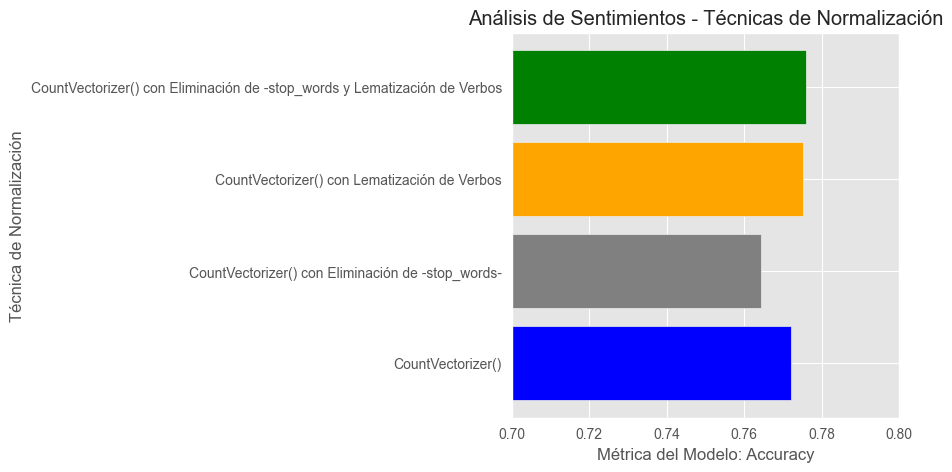

In [15]:
# Celda 5
# Resumen de los resultados de los diferentes modelos
resultados = {
    'CountVectorizer()': accuracy_cv,
    'CountVectorizer() con Eliminación de -stop_words-': accuracy_sw,
    'CountVectorizer() con Lematización de Verbos': accuracy_lm,
    'CountVectorizer() con Eliminación de -stop_words y Lematización de Verbos': accuracy
}

# Definición del mejor y el peor desempeño
mejor_modelo = max(resultados, key=resultados.get)
peor_modelo = min(resultados, key=resultados.get)

# Comentarios sobre los resultados
print(f"El mejor modelo para el Análisis de Sentimientos es el que usa la técnica: {mejor_modelo}, con una métrica Accuracy de: {resultados[mejor_modelo]:.5}.")
print(f"El peor modelo para el Análisis de Sentimientos es el que usa la técnica: {peor_modelo}, con una métrica Accuracy de: {resultados[peor_modelo]:.5}.")


figure = pd.DataFrame(list(resultados.items()), columns=['Técnica', 'Métrica'])
plt.figure(figsize=(5, 5))
plt.barh(figure['Técnica'], figure['Métrica'], color=['blue', 'gray','orange', 'green'])

plt.xlabel('Métrica del Modelo: Accuracy') 
plt.ylabel('Técnica de Normalización')
plt.title('Análisis de Sentimientos - Técnicas de Normalización')
plt.xlim(0.7, 0.8);

La gráfica muestra la comparación de las diferentes técnicas de vectorización y normalización empleadas en un modelo de RF para el análisis de sentimientos. Se observa que el modelo que integra tanto la eliminación de palabras irrelevantes (-stop_words-) como la lematización de verbos logra una mayor precisión (Accuracy), alcanzando un valor aproximado de 0.7761. Esta mejora en el desempeño con respecto al modelo base, se logra con la eliminación de variables (palabras) que no aportan poder de predicción (-stop_words-) al modelo mientras que se incrementa la correlación entre las palabras y la variable dependiente (sentimiento) gracias a la lematización.

Por otro lado, el modelo que solo aplica la eliminación de palabras irrelevantes(-stop_words-) registra la precisión más baja, del orden de 0.7645. Esta reducción en el desempeño del modelo se atribuye a la disminución de variables predictoras dada la eliminación de palabras irrelevantes (-stop_words-) al mismom tiempo que se mantinen las palabras restantes con un correlación baja con respecto a la variable dependiente.

En conclusión, es notorio que el preprocesamiento de lenguaje como la lematización y la eliminación de palabras irrelevantes pueden incrementar la precisión en los modelos de análisis de sentimientos. Adicionalmente, es recomendable aplicar varias técnicas de manera conjunta.